# Problem2
### 20191128 Jian Park

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# label
categories = ['brontosaurus', 'car_side', 'cougar_face', 'dalmatian', 'dollar_bill', 'dragonfly', 'Faces', 'Faces_easy', 'flamingo', 'headphone', 'lotus', 'menorah', 'nautilus', 'pagoda', 'soccer_ball', 'stop_sign', 'sunflower', 'tick', 'windsor_chair', 'yin_yang']
detector = cv2.ORB_create() # use ORB feature descriptor

In [3]:
def reset_train():
	train_path = 'dataset/train'
	train_paths = []
	train_labels = []
	train_features = np.array([]) # save train image feature
	img_len = 30 # (# of train image for each class)

	for idx, category in enumerate(categories):
		dir_path = train_path + '/' + category
		
		for i in range(img_len):
			img_path = dir_path + '/' + 'image_%04d.jpg' % (i+1)
			train_paths.append(img_path)
			train_labels.append(idx)
			img = cv2.imread(img_path)
			gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
			kpt, desc = detector.detectAndCompute(gray, None) # extract feature of image

			if train_features.size == 0:
				train_features = np.float32(desc)
			else:
				train_features = np.append(train_features, np.float32(desc), axis=0)

	return train_paths, train_labels, train_features

In [4]:
def reset_test():
	test_path = 'dataset/test'
	test_paths = []
	test_labels = []
	test_features= []
	test_img_len = 5 # (# of test image for each class)

	for idx, category in enumerate(categories):
		dir_path = test_path + '/' + category
		
		for i in range(30, 30+test_img_len):
			img_path = dir_path + '/' + 'image_%04d.jpg' % (i+1)
			test_paths.append(img_path)
			test_labels.append(idx)
			img = cv2.imread(img_path)
			gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
			kpt, desc = detector.detectAndCompute(gray, None)

			test_features.append(desc)

	return test_paths, test_labels, test_features

In [5]:
def setKmeans(train_features, word_size, save_mode):
  dict_file = 'dictionary.npy'
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)
  ret, label, dictionary = cv2.kmeans(train_features, word_size, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  if save_mode:
    np.save(dict_file, dictionary)

  return dictionary

In [6]:
def setKNN(train_paths, dictionary, word_size, save_mode):
  knn_model_file = 'nearest_neighbor.xml'
  knn = cv2.ml.KNearest_create() # use K-NN
  knn.train(dictionary, cv2.ml.ROW_SAMPLE, np.float32(range(word_size)))
  train_desc = np.float32(np.zeros((len(train_paths), word_size)))

  for i, path in  enumerate(train_paths):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kpt, desc = detector.detectAndCompute(gray, None)

    ret, result, neighbours, dist = knn.findNearest(np.float32(desc), k=1)
    hist, bins = np.histogram(np.int32(result), bins=range(word_size + 1))
    train_desc[i, :] = np.float32(hist) / np.float32(np.sum(hist))

  if save_mode:
    knn.save(knn_model_file)
  return knn, train_desc

In [7]:
def trainSVM(train_labels, train_desc, word_size, kernel, save_mode):
  svm_model_file = 'svmmodel.xml'
  svm = cv2.ml.SVM_create()
  svm.setKernel(kernel)
  svm.trainAuto(train_desc, cv2.ml.ROW_SAMPLE, np.array(train_labels)) # C, Gamma 를 자동으로 최적화해서 train

  if save_mode:
    svm.save(svm_model_file) # train 시킨 모델 저장
  return svm

In [8]:
def test(test_features, test_labels, svm, knn, word_size):
  test_desc = np.float32(np.zeros((len(test_features), word_size)))
  corr = 0

  for i, desc in enumerate(test_features):
    ret, result, neighbours, dist = knn.findNearest(np.float32(desc), k=1)
    hist, bins = np.histogram(np.int32(result), bins=range(word_size + 1))
    test_desc[i, :] = np.float32(hist) / np.float32(np.sum(hist))
    
  ret, result = svm.predict(test_desc)

  for i in range(len(test_features)):
    pred = int(result[i][0])
    if pred == test_labels[i]:
      corr += 1

  accuracy = corr / len(test_features)

  return accuracy

In [9]:
# 2-1
train_paths, train_labels, train_features = reset_train()
test_paths, test_labels, test_features = reset_test()

size = 50
dictionary = setKmeans(train_features, size, True)
knn, train_desc = setKNN(train_paths, dictionary, size, True)
svm = trainSVM(train_labels, train_desc, size, cv2.ml.SVM_RBF, True)
accuracy = test(test_features, test_labels, svm, knn, size)
print(accuracy)

0.42


In [10]:
# 2-2
# train_paths, train_labels, train_features = reset_train()
# test_paths, test_labels, test_features = reset_test()

word_size = np.array([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
acc = np.zeros(11)

for i in range(11):
  size = word_size[i]
  dictionary = setKmeans(train_features, size, False)
  knn, train_desc = setKNN(train_paths, dictionary, size, False)
  svm = trainSVM(train_labels, train_desc, size, cv2.ml.SVM_RBF, False)
  accuracy = test(test_features, test_labels, svm, knn, size)
  acc[i] = accuracy
  print(accuracy)

0.05
0.31
0.35
0.41
0.39
0.43
0.42
0.44
0.43
0.43
0.36


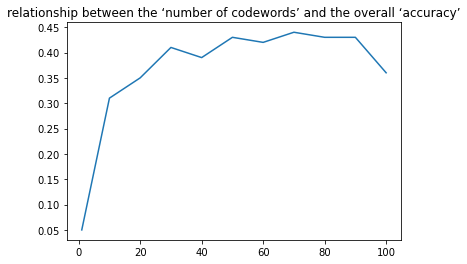

In [11]:
plt.plot(word_size, acc)
plt.title('relationship between the ‘number of codewords’ and the overall ‘accuracy’')
plt.show()

In [12]:
# 2-3 histogram intersection kernel
# train_paths, train_labels, train_features = reset_train()
# test_paths, test_labels, test_features = reset_test()

word_size = np.array([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
acc = np.zeros(11)

for i in range(11):
  size = word_size[i]
  dictionary = setKmeans(train_features, size, False)
  knn, train_desc = setKNN(train_paths, dictionary, size, False)
  svm = trainSVM(train_labels, train_desc, size, cv2.ml.SVM_INTER, False)
  accuracy = test(test_features, test_labels, svm, knn, size)
  acc[i] = accuracy
  print(accuracy)

0.05
0.31
0.37
0.41
0.42
0.48
0.49
0.52
0.48
0.54
0.52


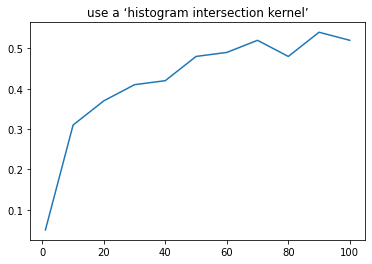

In [13]:
plt.plot(word_size, acc)
plt.title('use a ‘histogram intersection kernel’')
plt.show()